In [70]:
import lightkurve
import eleanor
import pickle
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from lightkurve import search_lightcurvefile
from numpy import loadtxt
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
from astropy.io import fits
from lowess_detrend import lowess_detrending
from utility_belt import phase_fold_plot
from astropy.timeseries import BoxLeastSquares
plt.ion()

Open lightcurve file and plot lc

In [71]:
target_ID = "TIC-425162657"
filename = '/Users/mbattley/Documents/PhD/NGTS/tessFFIextract/TIC-425162657.fits'

hdul = fits.open(filename)
data = hdul[1].data

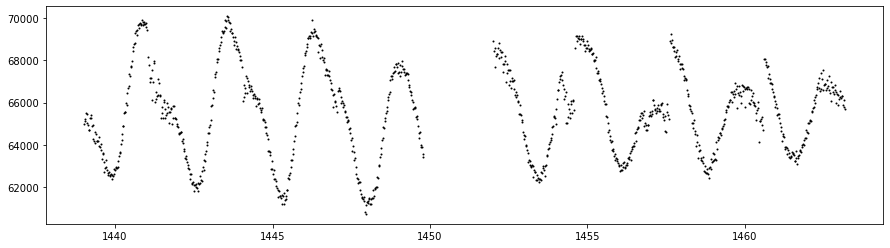

In [90]:
time = data['BJD']
flux = data['COR_AP2.5']

mask = np.ones(len(time), dtype=bool)
for n in range(len(time)):
    if flux[n] == -99.:
        mask[n] = False

masked_time = time[mask] -2457000
masked_flux = flux[mask]
        
plt.figure(figsize=(15,4))
plt.scatter(masked_time,masked_flux,s=1,c='k')
plt.show()


Detrend with lowess

/Users/mbattley/Documents/PhD/Python/lowess_detrend.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  overplotted_detrending_fig.show()
/Users/mbattley/Documents/PhD/Python/lowess_detrend.py:139: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  residuals_after_lowess_fig.show()


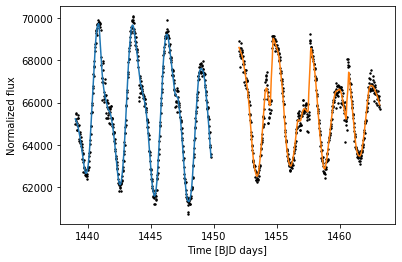

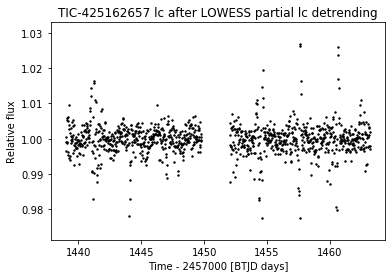

In [73]:
detrended_flux, full_lowess_flux = lowess_detrending(flux=masked_flux, time=masked_time,target_ID=target_ID, pipeline='SG',n_bins=20)



Perform BLS 

{'transit_times': <Quantity [1444.08871414, 1450.80100816, 1457.51330219] d>, 'per_transit_count': array([5, 0, 7]), 'per_transit_log_likelihood': array([0.00041507, 0.        , 0.00040453]), 'depth': (0.011687581470477881, 0.29034058188207956), 'depth_phased': (-0.002945710461979334, 0.19862189744592654), 'depth_half': (0.001652006209171053, 0.16524197153618664), 'depth_odd': (0.011687581470477881, 0.29034058188207956), 'depth_even': (0.0, inf), 'harmonic_amplitude': 0.00020285772660964233, 'harmonic_delta_log_likelihood': -0.0007988627752873682}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


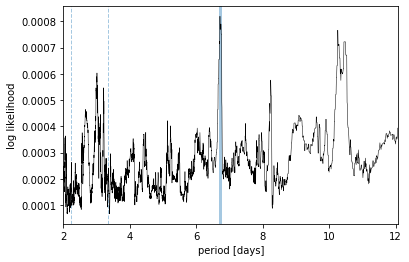

In [74]:
durations = np.linspace(0.05, 1, 100) * u.day

BLS_flux = detrended_flux

model = BoxLeastSquares(masked_time*u.day, BLS_flux)
results = model.autopower(durations, minimum_n_transit=3,frequency_factor=1.0)
            
# Find the period and epoch of the peak
index = np.argmax(results.power)
period = results.period[index]

t0 = results.transit_time[index]
duration = results.duration[index]
transit_info = model.compute_stats(period, duration, t0)
print(transit_info)

epoch = transit_info['transit_times'][0]

periodogram_fig, ax = plt.subplots(1, 1)
# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot and save the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")
#if use_TESSflatten == True:
    #ax.set_title('{} - BLS Periodogram with TESSflatten'.format(target_ID))
#            periodogram_fig.savefig(save_path + '{} - BLS Periodogram with TESSflatten.png'.format(target_ID))
#else:
#                ax.set_title('{} - BLS Periodogram after {} detrending - {}R {}d injected planet'.format(target_ID, detrending, params.rp, params.per))
#                ax.set_title('{} - BLS Periodogram after {} detrending'.format(target_ID, detrending))
#                periodogram_fig.savefig(save_path + '{} - BLS Periodogram after lowess partial detrending - {}R {}d injected planet.png'.format(target_ID, params.rp, params.per))
    #periodogram_fig.savefig(save_path + '{} - BLS Periodogram after lowess partial detrending.png'.format(target_ID))
#            plt.close(periodogram_fig)
periodogram_fig.show()

Phase fold

(0.4, 0.6)

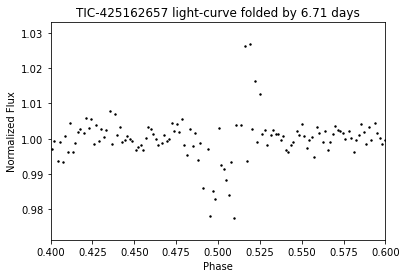

In [86]:
title=True
period = results.period[index].value
phase = np.mod(masked_time-epoch-period/2,period)/period 

phase_fold_fig  = plt.figure()
plt.scatter(phase, detrended_flux, c='k', s=2)
if title == True:
    plt.title('{} light-curve folded by {:.3} days'.format(target_ID,period))
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.xlim(0.4,0.6)
